In [38]:
import os
from PIL import Image
import csv
import numpy as np

base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'dataset')
fer2013_csv = os.path.join(dataset_dir, 'fer2013.csv')
fer2013 = os.path.join(dataset_dir, 'fer2013')
snips = os.path.join(base_dir, 'snips')

# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
digit2emotions = {'0': 'Angry', '1': 'Disgust', '2': 'Fear',
                '3': 'Happy', '4': 'Sad', '5': 'Surprise',
                '6': 'Neutral'}

def pixel2image(pixels, dst_dir, fname, mode='L'):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    img_path = os.path.join(dst_dir, fname)
    im = Image.fromarray(pixels).convert(mode)
    im.save(img_path)

def csv2image():
    with open(fer2013_csv) as f:
        file = csv.reader(f)
        next(file)
        indices = 0        
        for labels, pixels, tra_test in file:
            if tra_test == 'Training' and labels == '2':
                pixels = pixels.split()
                pixels = np.asarray(pixels, dtype=np.uint8).reshape(48, 48)                   
                subdir = os.path.join(fer2013, tra_test)
                emotions = digit2emotions[labels]
                dst_dir = os.path.join(subdir, emotions)
                pixel2image(pixels, dst_dir, '{}.{}.jpg'.format(emotions, indices))
                indices += 1
        print(indices)

In [39]:
csv2image()

4097


In [25]:
from matplotlib import pyplot as plt

def plt_pie_of_train_dataset():
    labels, num = [], []
    for rt, dirs, files in os.walk(fer2013):
        if not dirs:
            path_dir = rt.split('\\')
            if path_dir[-2] == 'Training': # count the number of each emotions
                labels.append(path_dir[-1])
                num.append(len(files))
                
      
    print(dict(zip(labels, num)))
    plt.pie(num, labels=labels, autopct='%1.1f%%')
    plt.title('The ratio of each emotion in train dataset')
    filename = 'The ratio of each emotion in train dataset.png'
    plt.savefig(os.path.join(snips, filename))
    plt.show()

{'Happy': 7215, 'Surprise': 3171, 'Sad': 4830, 'Neutral': 4965, 'Disgust': 436, 'Angry': 3995, 'Fear': 4097}


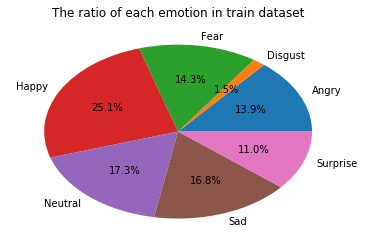

In [26]:
plt_pie_of_train_dataset()

In [27]:
from matplotlib import pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plt_acc_loss(history, acc_title, loss_title, acc_filepath=None, loss_filepath=None):
    """ plt the accuracy and the loss picture in `history`, and save 
    the figure to png directory with title name"""
    if not acc_filepath:
        acc_filepath = acc_title        
    if not loss_filepath:
        loss_filepath = loss_title
    acc_filepath = os.path.join(snips, acc_filepath)
    loss_filepath = os.path.join(snips, loss_filepath)
        
    acc = smooth_curve(history.history['acc'])
    val_acc = smooth_curve(history.history['val_acc'])
    loss = smooth_curve(history.history['loss'])
    val_loss = smooth_curve(history.history['val_loss'])

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(acc_title)
    plt.legend()
    plt.grid(True)
    plt.savefig(acc_filepath)
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(loss_title)
    plt.grid(True)
    plt.legend()
    plt.savefig(loss_filepath)
    plt.show()

In [31]:
from keras.preprocessing.image import ImageDataGenerator

def image_data_generator(data_dir, data_augment=False, batch_size=20, target_size=(48, 48),
                         color_mode='grayscale', class_mode='categorical', shuffle=True):
    if data_augment:
        datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(data_dir,
                                            target_size=target_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            class_mode=class_mode)
    return generator

Using TensorFlow backend.


In [ ]:
def evaluate_model(model=None, filepath=None):
    if not model:
        model = models.load_model(filepath)
    test_generator = image_data_generator(test_dir, batch_size=1, shuffle=False)
    
    nb_samples = len(test_generator)
    predict = model.evaluate_generator(test_generator, steps=nb_samples)
    # predictions = model.predict_generator(test_generator, steps=nb_samples)
    # val_preds = np.argmax(predictions, axis=-1)
    # val_trues = validation_generator.classes
    # cm = classification_report(val_trues, val_preds)    
    return predict

In [ ]:
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras import models
import numpy as np
# from keras.utils.np_utils import categorical_probas_to_classes # ImportError?

test_generator = image_data_generator(test_dir, shuffle=False, batch_size=1)

def probas_to_classes(y_pred):
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        return np.argmax(y_pred, axis=1)
    return np.array([1 if p > 0.5 else 0 for p in y_pred])

def evaluate_emotions_error_rate(model, sample_count=3589, batch_size=1):
    """evaluate the error rate of each emotion"""   
    Y_test = np.zeros(shape=sample_count)
    Y_pred = np.zeros(shape=sample_count)
    i = 0
    for X, labels_batch in test_generator:
        # Y_pred[i] = model.predict_classes(X)
        pred = model.predict(X)
        Y_pred[i] = probas_to_classes(pred)
        Y_test[i*batch_size: (i+1)*batch_size] = np.argmax(labels_batch, axis=1)  # convert one=hot encode to index
        i += 1   
        if i * batch_size >= 3589:
            break
    x_num, y_num = [0]*7, [0]*7    
    for pred, test in zip(Y_pred, Y_test):
        y_num[int(test)] += 1
        if pred != test: # predict error
            x_num[int(test)] += 1
            
    err = [i/j for i, j in zip(x_num, y_num)]
    return err

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plt_emotions(err, title):
    s = pd.Series(
        err,
        index = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    )

    plt.title(title)
    plt.ylabel('error rate')
    plt.xlabel('emotions')

    #Plot the data:
    my_colors = 'rykgmbc' # red yellow black green .. blue ..    

    s.plot(
        kind='bar', 
        color=my_colors,
    )
    pngfile = os.path.join(snips, title+'.png')
    plt.savefig(pngfile)
    plt.show()

In [ ]:
def save_model(model, filename):
    Models = os.path.join(os.getcwd(), 'Models')
    filepath = os.path.join(Models, filename)
    if filename.endswith('h5'):
        model.save(filepath)
    elif filename.endswith('json'):
        model.to_json(filepath)

from keras import models

def load_model(filename):
    Model = os.path.join(os.getcwd(), 'Models')
    filepath = os.path.join(Model, filename)
    model = None
    if filename.endswith('h5'):
        model = models.load_model(filepath)
    elif filename.endswith('json'):
        with open('model.json', 'r') as json_file:
            loaded_model_json = json_file.read()           
            model = models.model_from_json(loaded_model_json)
    return model


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers.core import Flatten


def feature_extractor_to_svm(directory, model, core=Flatten, layer_name=None, batch_size=20):    
    layer_output = -1
    for layer in model.layers:
        if layer_name:
            if layer.name == layer_name:
                layer_output = layer.output_shape[1]
        else:
            assert(isinstance(layer, Flatten))            
            layer_name = layer.name
            layer_output = layer.output_shape[1]
            
    intermediate_layer_model = Model(inputs=model.input,  # model.input
                                     outputs=model.get_layer(layer_name).output)
    
    assert(layer_output != -1)
    
    generator = image_data_generator(directory, batch_size=batch_size)
    if batch_size != 1:
        sample_count = len(image_data_generator(directory, batch_size=1))
    else:
        sample_count = len(generator) 
    print(os.path.split(directory)[-1], ': ', sample_count)
    
    features = np.zeros(shape=(sample_count, layer_output))  # the shape of flatten layer output
    labels = np.zeros(shape=(sample_count))
    # without data generator    
    i = 0
    for inputs_batch, labels_batch in generator:        
        intermediate_output = intermediate_layer_model.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size] = intermediate_output
        labels[i*batch_size: (i+1)*batch_size] = np.argmax(labels_batch, axis=1)  # one hot encoding to scalar enconde
        i += 1
        if i * batch_size >= sample_count:
            break
    np.reshape(features, (sample_count, layer_output))
    return features, labels